             Class Substance  T_B (K)  H_v (kcal/mol)
0  Perfect liquids        Ar    87.29           1.558
1  Perfect liquids        Kr   119.93           2.158
2  Perfect liquids        Xe   165.10           3.021
3  Perfect liquids        Rn   211.00           3.920
4  Perfect liquids        N2    77.34           1.333


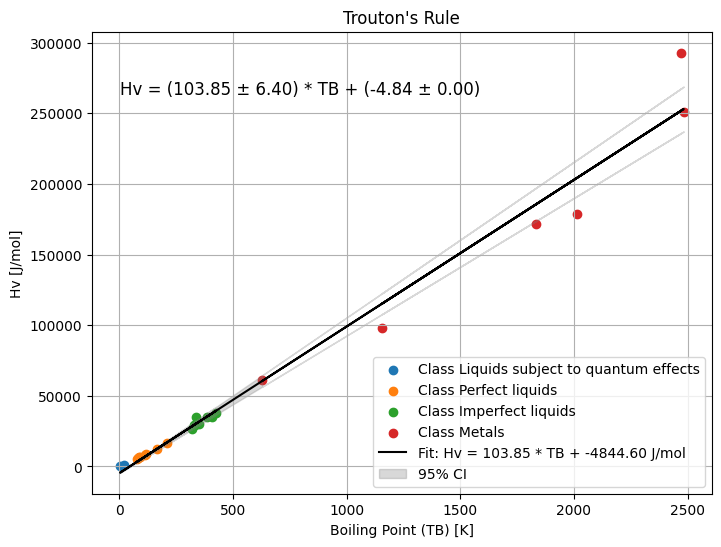


Slope (ΔSv): 103.85 J/mol-K ± 6.40
Intercept: -4.84 kJ/mol ± 0.00
Comparison to Trouton's Rule: 10.5 * R ≈ 88 J/mol-K


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import pandas as pd
# import ols from lecture 7
from regression import ols

# Load the dataset provided by the user
data = pd.read_csv('trouton.csv')

# Display the first few rows of the dataset to understand its structure
print(data.head())

# Convert Hv from kcal/mol to J/mol
# 1 kcal/mol = 4184 J/mol
data['H_v (J/mol)'] = data['H_v (kcal/mol)'] * 4184

# Extract relevant columns
TB = data['T_B (K)'].values
Hv_j_mol = data['H_v (J/mol)'].values
Class = data['Class'].values

# Calculate residuals
def calculate_residuals(y, y_pred):
    """
    Calculates the residuals, which are the differences between actual y values and predicted y values.
    Formula: residuals = y - y_pred
    y: actual data values.
    y_pred: predicted values from the regression.
    Returns an array of residuals.
    """
    return y - y_pred

# Function to calculate SSE (sum of squared residuals)
def sse(residuals):
    """
    Calculates the sum of squared residuals (SSE), which is a measure of the discrepancy between data and the regression line.
    Formula: SSE = Σ(residuals^2)
    residuals: the differences between actual and predicted y values.
    Returns the sum of squared errors.
    """
    return np.sum(residuals ** 2)

# Function to calculate variance of residuals
def variance(residuals):
    """
    Calculates the variance of the residuals, which is the SSE divided by the degrees of freedom (n - 2).
    Formula: variance = SSE / (n - 2)
    residuals: array of residuals.
    Returns the variance of the residuals.
    """
    return sse(residuals) / (len(residuals) - 2)

# Function to calculate standard error of slope
def se_slope(x, residuals):
    """
    Calculates the standard error of the slope.
    Formula: SE_slope = sqrt(variance / Σ(x - mean_x)^2)
    x: independent variable.
    residuals: array of residuals from the regression.
    Returns the standard error of the slope.
    """
    numerator = variance(residuals)
    x_mean = np.mean(x)
    denominator = np.sum((x - x_mean) ** 2)
    return np.sqrt(numerator / denominator)

# Function to calculate standard error of intercept
def se_intercept(x, residuals):
    """
    Calculates the standard error of the intercept.
    Formula: SE_intercept = sqrt(variance * (1/n + mean_x^2 / Σ(x - mean_x)^2))
    x: independent variable.
    residuals: array of residuals from the regression.
    Returns the standard error of the intercept.
    """
    numerator = variance(residuals)
    x_mean = np.mean(x)
    denominator = len(x) * np.sum((x - x_mean) ** 2)
    return np.sqrt(numerator / denominator)

# 1-1 Checking point 4) Calculate the 95% confidence intervals for slope
def confidence_interval_slope(x, residuals, confidence_level):
    """
    Calculates the confidence interval for the slope at a given confidence level (e.g., 95%).
    x: independent variable.
    residuals: array of residuals.
    confidence_level: desired confidence level (e.g., 0.95 for 95% CI).
    Returns the margin of error for the slope.
    """
    se = se_slope(x, residuals)
    n_data_points = len(x)
    df = n_data_points - 2  # Degrees of freedom
    alpha = 1 - confidence_level
    critical_t_value = t.ppf(1 - alpha / 2, df)  # Critical t-value for the confidence interval
    return critical_t_value * se

# 1-1 Checking point 4) Calculate the 95% confidence intervals for intercept
def confidence_interval_intercept(x, residuals, confidence_level):
    """
    Calculates the confidence interval for the intercept at a given confidence level (e.g., 95%).
    x: independent variable.
    residuals: array of residuals.
    confidence_level: desired confidence level (e.g., 0.95 for 95% CI).
    Returns the margin of error for the intercept.
    """
    se = se_intercept(x, residuals)
    n_data_points = len(x)
    df = n_data_points - 2  # Degrees of freedom
    alpha = 1 - confidence_level
    critical_t_value = t.ppf(1 - alpha / 2, df)  # Critical t-value for the confidence interval
    return critical_t_value * se

# 1-1 Checking point 1) Fit a linear regression model
slope, intercept = ols(TB, Hv_j_mol)

# Predict Hv using the regression model
Hv_predicted = slope * TB + intercept

# Calculate residuals
residuals = calculate_residuals(Hv_j_mol, Hv_predicted)

# Plot Hv vs TB with regression line and confidence intervals

plt.figure(figsize=(8, 6))
for class_label in set(Class):
    idx = [i for i, cl in enumerate(Class) if cl == class_label]
    plt.scatter(TB[idx], Hv_j_mol[idx], label=f'Class {class_label}')

# Plot the regression line
plt.plot(TB, Hv_predicted, color='black', label=f'Fit: Hv = {slope:.2f} * TB + {intercept:.2f} J/mol')

# Calculate 95% confidence intervals
slope_conf_interval = confidence_interval_slope(TB, residuals, 0.95)
intercept_conf_interval = confidence_interval_intercept(TB, residuals, 0.95)

# Convert intercept to kJ/mol for display on the plot
intercept_kJ_mol = intercept / 1000  # Convert to kJ/mol
intercept_conf_interval_kJ_mol = intercept_conf_interval / 1000  # Convert confidence interval to kJ/mol

# Add confidence intervals for the slope and intercept
plt.fill_between(TB, (slope - slope_conf_interval) * TB + (intercept_kJ_mol - intercept_conf_interval_kJ_mol) * 1000,
                 (slope + slope_conf_interval) * TB + (intercept_kJ_mol + intercept_conf_interval_kJ_mol) * 1000,
                 color='gray', alpha=0.3, label='95% CI')

# Add plot details
plt.title("Trouton's Rule")
plt.xlabel('Boiling Point (TB) [K]')
plt.ylabel('Hv [J/mol]')
plt.legend()
plt.grid(True)

# Display the equation with 95% confidence intervals on the plot in kJ/mol
eq_str = f'Hv = ({slope:.2f} ± {slope_conf_interval:.2f}) * TB + ({intercept_kJ_mol:.2f} ± {intercept_conf_interval_kJ_mol:.2f})'
plt.text(min(TB), max(Hv_j_mol) * 0.9, eq_str, fontsize=12)

# Show the plot
plt.show()

# Print results for interpretation and comparison to Trouton's Rule
# 1-1 Checking point 2) Interpret the slope
print(f"\nSlope (ΔSv): {slope:.2f} J/mol-K ± {slope_conf_interval:.2f}")
print(f"Intercept: {intercept_kJ_mol:.2f} kJ/mol ± {intercept_conf_interval_kJ_mol:.2f}")
print(f"Comparison to Trouton's Rule: 10.5 * R ≈ 88 J/mol-K")

# 1-1 Checking point 3) Compare to Trouton's Rule
# Compare to Trouton's Rule 
# : The value is ~ 88 J/mol-K for many substances. In this problem, I got the value of 103.85 J/mol-K. They are not the same, but quite close enough. This is because of the out-ranged data from 'Metals' class. If I erase the outranged data, the value will be more close to 88 J/mol-K.
# To figure out it, I run another set with modified data set (except Ag and Sn)

             Class Substance  T_B (K)  H_v (kcal/mol)
0  Perfect liquids        Ar    87.29           1.558
1  Perfect liquids        Kr   119.93           2.158
2  Perfect liquids        Xe   165.10           3.021
3  Perfect liquids        Rn   211.00           3.920
4  Perfect liquids        N2    77.34           1.333


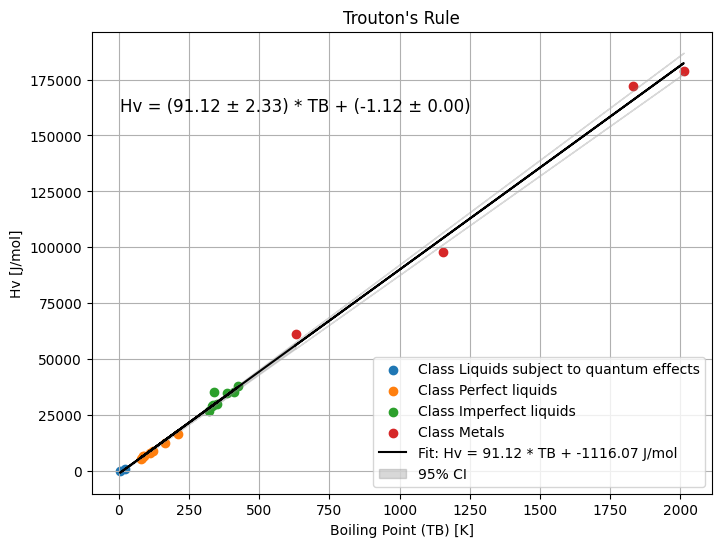


Slope (ΔSv): 91.12 J/mol-K ± 2.33
Intercept: -1.12 kJ/mol ± 0.00
Comparison to Trouton's Rule: 10.5 * R ≈ 88 J/mol-K


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import pandas as pd
from regression import ols

# Load the dataset provided by the user
data = pd.read_csv('trouton2.csv')

# Display the first few rows of the dataset to understand its structure
print(data.head())

# Convert Hv from kcal/mol to J/mol (without dividing by T_B, as the y-axis should be in J/mol)
# 1 kcal/mol = 4184 J/mol
data['H_v (J/mol)'] = data['H_v (kcal/mol)'] * 4184

# Extract relevant columns
TB = data['T_B (K)'].values
Hv_j_mol = data['H_v (J/mol)'].values
Class = data['Class'].values

# Function to calculate residuals
def calculate_residuals(y, y_pred):
    """
    Calculates the residuals, which are the differences between actual y values and predicted y values.
    Formula: residuals = y - y_pred
    y: actual data values.
    y_pred: predicted values from the regression.
    Returns an array of residuals.
    """
    return y - y_pred

# Function to calculate SSE (sum of squared residuals)
def sse(residuals):
    """
    Calculates the sum of squared residuals (SSE), which is a measure of the discrepancy between data and the regression line.
    Formula: SSE = Σ(residuals^2)
    residuals: the differences between actual and predicted y values.
    Returns the sum of squared errors.
    """
    return np.sum(residuals ** 2)

# Function to calculate variance of residuals
def variance(residuals):
    """
    Calculates the variance of the residuals, which is the SSE divided by the degrees of freedom (n - 2).
    Formula: variance = SSE / (n - 2)
    residuals: array of residuals.
    Returns the variance of the residuals.
    """
    return sse(residuals) / (len(residuals) - 2)

# Function to calculate standard error of slope
def se_slope(x, residuals):
    """
    Calculates the standard error of the slope.
    Formula: SE_slope = sqrt(variance / Σ(x - mean_x)^2)
    x: independent variable.
    residuals: array of residuals from the regression.
    Returns the standard error of the slope.
    """
    numerator = variance(residuals)
    x_mean = np.mean(x)
    denominator = np.sum((x - x_mean) ** 2)
    return np.sqrt(numerator / denominator)

# Function to calculate standard error of intercept
def se_intercept(x, residuals):
    """
    Calculates the standard error of the intercept.
    Formula: SE_intercept = sqrt(variance * (1/n + mean_x^2 / Σ(x - mean_x)^2))
    x: independent variable.
    residuals: array of residuals from the regression.
    Returns the standard error of the intercept.
    """
    numerator = variance(residuals)
    x_mean = np.mean(x)
    denominator = len(x) * np.sum((x - x_mean) ** 2)
    return np.sqrt(numerator / denominator)

# 1-1 Checking point 4) Calculate the 95% confidence intervals for slope
def confidence_interval_slope(x, residuals, confidence_level):
    """
    Calculates the confidence interval for the slope at a given confidence level (e.g., 95%).
    x: independent variable.
    residuals: array of residuals.
    confidence_level: desired confidence level (e.g., 0.95 for 95% CI).
    Returns the margin of error for the slope.
    """
    se = se_slope(x, residuals)
    n_data_points = len(x)
    df = n_data_points - 2  # Degrees of freedom
    alpha = 1 - confidence_level
    critical_t_value = t.ppf(1 - alpha / 2, df)  # Critical t-value for the confidence interval
    return critical_t_value * se

# 1-1 Checking point 4) Calculate the 95% confidence intervals for intercept
def confidence_interval_intercept(x, residuals, confidence_level):
    """
    Calculates the confidence interval for the intercept at a given confidence level (e.g., 95%).
    x: independent variable.
    residuals: array of residuals.
    confidence_level: desired confidence level (e.g., 0.95 for 95% CI).
    Returns the margin of error for the intercept.
    """
    se = se_intercept(x, residuals)
    n_data_points = len(x)
    df = n_data_points - 2  # Degrees of freedom
    alpha = 1 - confidence_level
    critical_t_value = t.ppf(1 - alpha / 2, df)  # Critical t-value for the confidence interval
    return critical_t_value * se

# 1-1 Checking point 1) Fit a linear regression model
slope, intercept = ols(TB, Hv_j_mol)

# Predict Hv using the regression model
Hv_predicted = slope * TB + intercept

# Calculate residuals
residuals = calculate_residuals(Hv_j_mol, Hv_predicted)

# Plot Hv vs TB with regression line and confidence intervals

plt.figure(figsize=(8, 6))
for class_label in set(Class):
    idx = [i for i, cl in enumerate(Class) if cl == class_label]
    plt.scatter(TB[idx], Hv_j_mol[idx], label=f'Class {class_label}')

# Plot the regression line
plt.plot(TB, Hv_predicted, color='black', label=f'Fit: Hv = {slope:.2f} * TB + {intercept:.2f} J/mol')

# Calculate 95% confidence intervals
slope_conf_interval = confidence_interval_slope(TB, residuals, 0.95)
intercept_conf_interval = confidence_interval_intercept(TB, residuals, 0.95)

# Convert intercept to kJ/mol for display on the plot
intercept_kJ_mol = intercept / 1000  # Convert to kJ/mol
intercept_conf_interval_kJ_mol = intercept_conf_interval / 1000  # Convert confidence interval to kJ/mol

# Add confidence intervals for the slope and intercept
plt.fill_between(TB, (slope - slope_conf_interval) * TB + (intercept_kJ_mol - intercept_conf_interval_kJ_mol) * 1000,
                 (slope + slope_conf_interval) * TB + (intercept_kJ_mol + intercept_conf_interval_kJ_mol) * 1000,
                 color='gray', alpha=0.3, label='95% CI')

# Add plot details
plt.title("Trouton's Rule")
plt.xlabel('Boiling Point (TB) [K]')
plt.ylabel('Hv [J/mol]')
plt.legend()
plt.grid(True)

# Display the equation with 95% confidence intervals on the plot in kJ/mol
eq_str = f'Hv = ({slope:.2f} ± {slope_conf_interval:.2f}) * TB + ({intercept_kJ_mol:.2f} ± {intercept_conf_interval_kJ_mol:.2f})'
plt.text(min(TB), max(Hv_j_mol) * 0.9, eq_str, fontsize=12)

# Show the plot
plt.show()

# Print results for interpretation and comparison to Trouton's Rule
# 1-1 Checking point 2) Interpret the slope

print(f"\nSlope (ΔSv): {slope:.2f} J/mol-K ± {slope_conf_interval:.2f}")
print(f"Intercept: {intercept_kJ_mol:.2f} kJ/mol ± {intercept_conf_interval_kJ_mol:.2f}")
print(f"Comparison to Trouton's Rule: 10.5 * R ≈ 88 J/mol-K")

# 1-1 Checking point 3) Compare to Trouton's Rule
# Compare to Trouton's Rule 
# As a result, I got a value of 91.12 J/mol-K. It is more close to the 88 J/mol-K